This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [59]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DFT.

Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N^2}\right)
$$

**Answers :**

The standard expression for the 2D DTFT is given by:

$$
A(\omega_x, \omega_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n, m) e^{-j(\omega_x n + \omega_y m)}
$$

where:
- $A(\omega_x, \omega_y)$ is the 2D DTFT of the signal $a(n, m)$,
- $\omega_x$ and $\omega_y$ are the angular frequencies in the x and y dimensions, respectively,
- $n$ and $m$ index the discrete points in the spatial (or temporal) domain,
- $j$ is the imaginary unit.

This expression effectively transforms a signal from the spatial domain (or time domain, depending on the context) into the frequency domain, allowing for the analysis of its frequency components.

The DTFT of $a(n, m)$ is given by:

$$
A(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n, m) e^{-i2\pi(\nu_x n + \nu_y m)}
$$

Given $b(n,m) = a(n+c,m+d)$, the DTFT of $b(n, m)$ can be expressed as:

$$
B(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} b(n, m) e^{-i2\pi(\nu_x n + \nu_y m)}
$$

Substituting \(b(n,m)\) with \(a(n+c,m+d)\), we get:

$$
B(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n+c, m+d) e^{-i2\pi(\nu_x n + \nu_y m)}
$$

Let's introduce a change of variables for the summation to account for the translation:
- Let \(n' = n + c\) and \(m' = m + d\). Thus, \(n = n' - c\) and \(m = m' - d\).

The equation becomes:

$$
B(\nu_x, \nu_y) = \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n', m') e^{-i2\pi(\nu_x (n'-c) + \nu_y (m'-d))}
$$

This can be simplified as:

$$
B(\nu_x, \nu_y) = e^{-i2\pi(c\nu_x + d\nu_y)} \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n', m') e^{-i2\pi(\nu_x n' + \nu_y m')}
$$

Recognizing the summation as the DTFT of \(a(n, m)\), we obtain:

$$
B(\nu_x, \nu_y) = A(\nu_x, \nu_y) \cdot e^{-i2\pi(c\nu_x + d\nu_y)}
$$

Hence, the ratio between the DTFTs of \(b\) and \(a\) is given by:

$$
\frac{B(\nu_x, \nu_y)}{A(\nu_x, \nu_y)} = e^{-i2\pi(c\nu_x + d\nu_y)}
$$

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

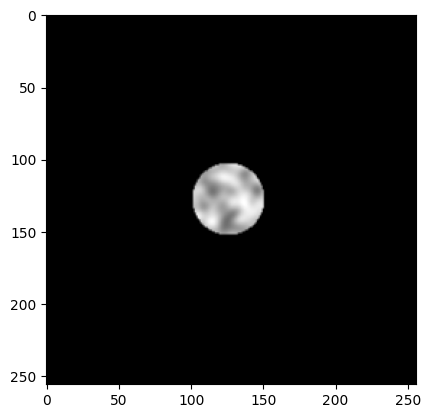

In [60]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)
plt.imshow(im1,cmap='gray')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1e580d48f90>)

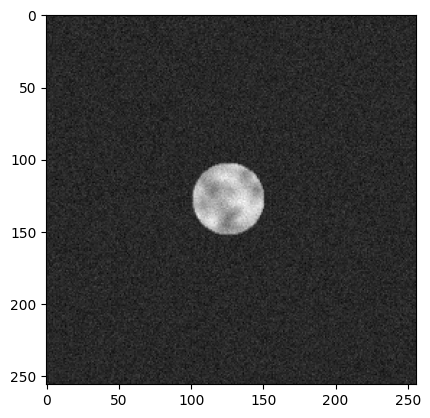

In [61]:
# Potentially add noise to the image
sigma = 10
im1_noise = im1 + sigma*np.random.randn(N, M)
plt.figure(),plt.imshow(im1_noise,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [62]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1e581845b50>)

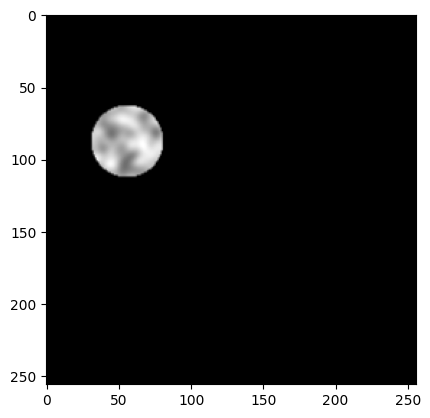

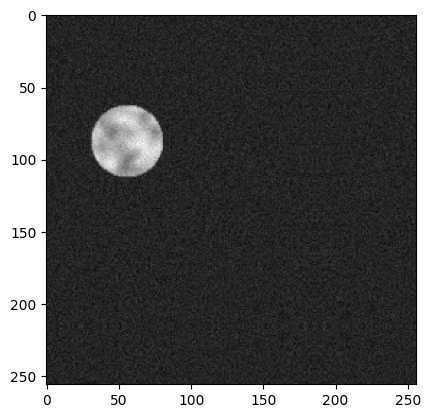

In [63]:
horiz_displacement = 70.
vert_displacement  = 40.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
im2_noise = applyAffineMotion(im1_noise,b)
plt.figure(),plt.imshow(im2,cmap='gray')
plt.figure(),plt.imshow(im2_noise,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

To compute the Fast Fourier Transform (FFT) of the two images (`im2` and `im2_noise`) and describe a method to find the parameters of the translation from the two FFTs, we follow a method based on properties of the Fourier Transform, specifically the translation property.

### Step 1: Compute the FFT of Both Images

First, we compute the FFT of both `im2` (the translated image) and `im2_noise` (the translated image with noise). This is achieved using the `numpy.fft.fft2` function, which computes the 2D discrete Fourier Transform of an image.

### Step 2: Apply the Translation Property

The translation property of the Fourier Transform states that a spatial translation of the image results in a phase shift in the Fourier domain, without altering the magnitude. This property can be mathematically represented as follows for the translation of an image $a(n,m)$ to $b(n,m) = a(n+c,m+d)$:

$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

where $\hat{a}(\nu_x,\nu_y)$ and $\hat{b}(\nu_x,\nu_y)$ are the FFTs of $a$ and $b$, respectively, and $c$ and $d$ are the horizontal and vertical displacements.

### Step 3: Finding the Translation Parameters

Given the FFTs of the original and translated images, the phase difference between them can be used to find the translation parameters $c$ and $d$. This involves:

1. Compute the phase difference between the FFTs of `im2` and `im2_noise` against the original image (`im1` and `im1_noise`). This is done by subtracting the phase of the FFT of the original image from the phase of the FFT of the translated image.
2. Analyze the phase difference to find $c$ and $d$. The phase difference $\Delta \phi(\nu_x,\nu_y) = 2\pi (c\nu_x + d \nu_y)$ is directly proportional to the translation parameters.
3. Solve for $c$ and $d$. Given that the phase difference is linearly related to $c$ and $d$, one can use techniques such as phase correlation to estimate these values.

In [64]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Phase Difference with Noise'))

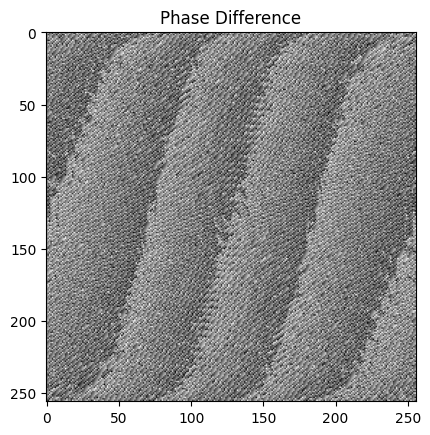

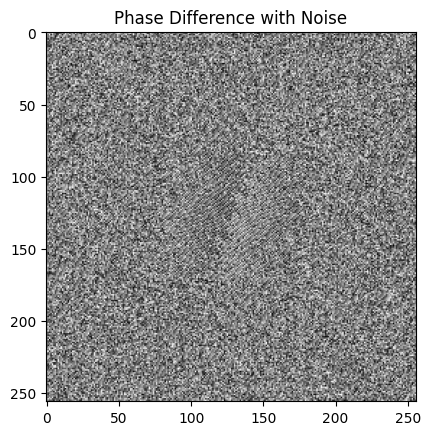

In [65]:
from scipy.fftpack import fftshift

# Compute FFTs
fft_im1 = np.fft.fft2(im1)
fft_im2 = np.fft.fft2(im2)
fft_im1_noise = np.fft.fft2(im1_noise)
fft_im2_noise = np.fft.fft2(im2_noise)

# Compute phase difference
phase_diff = np.angle(fft_im2) - np.angle(fft_im1)
phase_diff_noise = np.angle(fft_im2_noise) - np.angle(fft_im1_noise)

# Display phase difference
plt.figure(), plt.imshow(fftshift(phase_diff), cmap='gray'), plt.title('Phase Difference')
plt.figure(), plt.imshow(fftshift(phase_diff_noise), cmap='gray'), plt.title('Phase Difference with Noise')


Compute the phase of the Fourier transform.

In [66]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [67]:
phi = angle2D(IM2/IM1)
phi2 = angle2D(fft_im2_noise/fft_im1_noise)

print(phi)

[[ 35.         34.7265625  34.453125  ... -34.1796875 -34.453125
  -34.7265625]
 [ 34.84375    34.5703125  34.296875  ... -34.3359375 -34.609375
  -34.8828125]
 [ 34.6875     34.4140625  34.140625  ... -34.4921875 -34.765625
  -35.0390625]
 ...
 [ -4.53125    -4.8046875  -5.078125  ... -73.7109375 -73.984375
  -74.2578125]
 [ -4.6875     -4.9609375  -5.234375  ... -73.8671875 -74.140625
  -74.4140625]
 [ -4.84375    -5.1171875  -5.390625  ... -74.0234375 -74.296875
  -74.5703125]]


Display phi. Is it a linear plane and why?

The variable $ \phi $ represents the unwrapped phase difference between two images, IM2 and IM1, normalized by $-2\pi$. This process involves unwrapping the phase along both axes to mitigate discontinuities resulting from the angle function's periodicity, which confines values within $[-π, π]$. Unwrapping adjusts for phase jumps, ensuring smooth transitions across the image.

The appearance of $ \phi $ as a linear plane is attributed to the linear relationship between the phase shift caused by spatial translation and the image's frequencies ($ν_x, ν_y$) alongside the translation magnitude ($c, d$). This phase shift is mathematically articulated as $Δϕ(ν_x, ν_y) = 2π(cν_x + dν_y)$, indicating that the phase difference directly relates to the spatial frequencies and translation vector, manifesting as a linear plane in $ \phi $.

In essence, the linear character of $ \phi $ mirrors the direct correlation between the Fourier domain's phase shift and the image's spatial translation. This principle underpins methods like phase correlation, leveraging the linear phase relationship to deduce translations between images.

**Answer:**

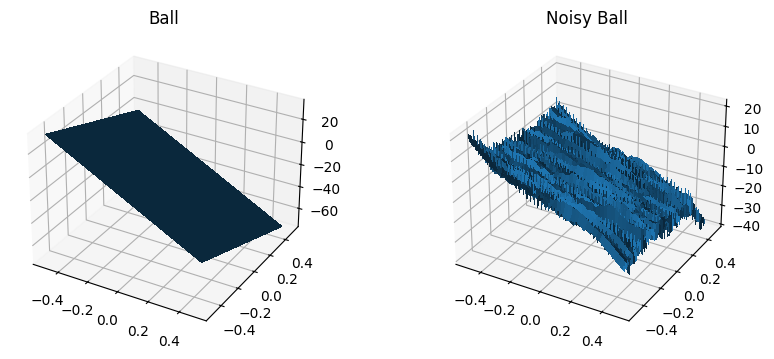

In [68]:
fig, axes = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 4))

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
surf = axes[0].plot_surface(fx, fy, phi, linewidth=0, antialiased=False)
axes[0].set_title('Ball')

fx2, fy2 = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
surf = axes[1].plot_surface(fx2, fy2, phi2, linewidth=0, antialiased=False)
axes[1].set_title('Noisy Ball')

plt.show()

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [69]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = np.diff(M, axis=0, prepend=M[0:1,:]) / stepY
    
    gx = np.diff(M, axis=1, prepend=M[:,0:1]) / stepX

    return gx, gy

In [70]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

gx2, gy2 = gradient(phi2,1/M,1/N)
GX2 = np.median(gx2)
GY2 = np.median(gy2)

print(GX,GY)
print(GX2,GY2)

-70.0 -40.0
-45.319820226419324 -9.745378401475307


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

The process of estimating translation parameters from the phase difference $ \phi $ involves several key steps designed to enhance accuracy and mitigate noise:

1. **Noise Reduction via Median Filtering**: The median filter is applied to $ \phi $, smoothing out noise and outliers by replacing each pixel's value with the median of its neighbors within a specified window. This step is crucial for cleaning the data, ensuring a more reliable estimation of translation parameters. Edge effects are managed by replicating border values, allowing uniform application of the filter across the entire image.

2. **Phase Difference Centralization**: By adjusting $ \phi $ to subtract the value at the image's center, the phase data is centralized. This adjustment aids in normalizing the phase difference, enhancing the robustness of the analysis against phase offsets.

3. **Data Smoothing and Preparation**: Following centralization, the median filter is applied again to smooth the phase difference further, preparing it for a more accurate least squares fitting process. The preparation involves organizing the frequency components and the filtered phase difference into matrices $ A $ and vector $ b $, respectively, setting the stage for the least squares computation.

4. **Computing the Least Squares Solution**: The pseudo-inverse of matrix $ A $ is calculated to deal with potential non-square matrices or linear dependencies. The multiplication of this pseudo-inverse by vector $ b $ yields solutions that approximate the best-fitting plane to the phase difference data, correlating directly with the image's translation parameters in both the x and y directions.

In [71]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [72]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

phi2 = phi2-phi2[int(N/2+2), int(M/2+2)]
t2 = medianFilter(phi2,1)
A2 = np.zeros((np.shape(fx2)[0]*np.shape(fx2)[1],2))
A2[:,0] = fx2.reshape(np.shape(fx2)[0]*np.shape(fx2)[1])
A2[:,1] = fy2.reshape(np.shape(fy2)[0]*np.shape(fy2)[1])
b2 = t2.reshape(np.shape(t2)[0]*np.shape(t2)[1])
bEst2 = np.dot(np.linalg.pinv(A2),b2)


In [73]:
print(bEst, bEst2)

[-69.99454246 -39.9999715 ] [-24.24887669 -13.70041449]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

The method of using a least squares planar approximation to decipher the phase difference effectively identifies the translation parameters, albeit with minor inaccuracies due to noise. A key step in enhancing the accuracy of this method, especially in the presence of noise, is the application of median filtering, which significantly aids in the extraction of translation parameters from the noisy image of the ball.

However, when applied to the image of the woman, this technique does not achieve as high precision. The image of the woman, characterized by its complex and varied structure, deviates from the simpler, more periodic nature of the ball images. This complexity is due to the diverse textures, edges, and patterns within the woman's image, complicating the phase difference in a way that resists simplification into a basic planar model. 

The efficacy of this method is more pronounced with images that display clear periodic structures and can somewhat counteract the effects of noise. Yet, its performance wanes when faced with images containing intricate, unique patterns. The underlying principle of the method—the expectation of a uniform phase shift corresponding to a translation—is more readily applicable to simpler, structured subjects like the ball. In contrast, this assumption falters with more complicated imagery, such as the woman's portrait, indicating the method's limitations with non-repetitive, complex patterns.

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

In [76]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """


    step = 8
    cont = 4*step

    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV=np.zeros(2)

    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC


    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)

    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]

    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]

    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]

        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]

        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)

    pV = pV.ravel()

    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect

    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    # Non-regularized search
    if lamb == 0.:
        for r in np.arange(0, cur.shape[0], brow) : # for each block in the current image, find the best corresponding block in the reference image
            for  c in np.arange(0, cur.shape[1], bcol) :  # x is the height and y is the length
                # current block selection
                B =  cur[r:r+brow, c: c+bcol]# Block

                # Initialization:
                bestD = None
                costMin = np.inf

                Rbest = None

                # Loop on candidate displacement vectors
                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search): # rcol = candidate displacement vector over the rows
                        C = ref_extended[r - drow + extension:r - drow + extension + brow, c - dcol + extension: c - dcol + extension + bcol]
                        cost = np.sum((B-C)**2)
                        d = np.array([drow, dcol])

                        if cost < costMin : # Save the results if they are better than the previous ones
                            Rbest = C
                            costMin = cost
                            bestD = d

                mvf[r:r+brow, c:c+bcol , 0] = bestD[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol , 1] = bestD[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest.reshape(brow,bcol)

    else: # Regularized search
        for r in np.arange(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for  c in np.arange(0, cur.shape[1], bcol) :
                # current block selection
                B = cur[r: r + brow, c: c + bcol] # Block

                # Initializations

                costMin = np.inf
                Rbest = None
                bestD = None

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)

                # Loop on candidate vectors
                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search): # rcol = candidate displacement vector over the rows
                        C = ref_extended[r - drow + extension: r - drow + extension + brow, c - dcol + extension: c - dcol + extension + bcol]
                        d = np.array([drow, dcol])

                        error = np.sqrt(np.sum((d - pV)**2))
                        cost = np.sum((B - C) ** 2) + lamb * error# here, encore the REGULARIZED cost function


                        if cost < costMin : # Save the results if they are better than the previous ones
                            Rbest = C
                            costMin = cost
                            bestD = d


                mvf[r:r+brow,c:c+bcol,0]= bestD[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= bestD[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest


    mvf = -mvf # For compatibility with standards

    return mvf, prediction

def displayMVF(I,mvf,subsamp):

    row,col = np.shape(I)

    # Subsample dense MVF
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]

    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)

    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    return

10.0
10.0
2.5
3.5


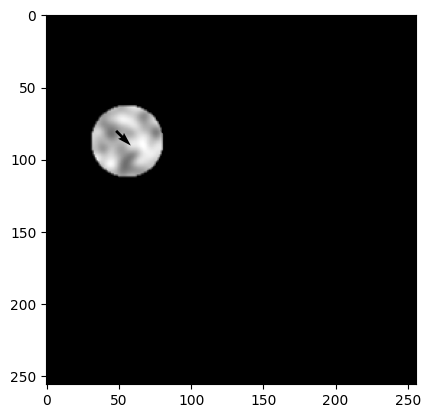

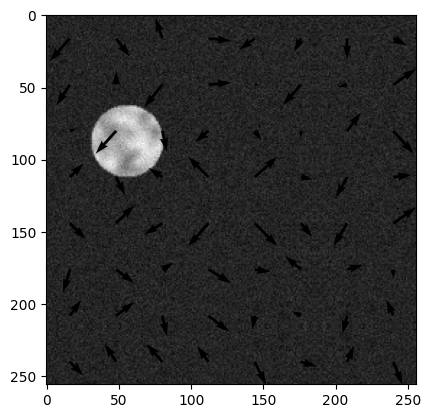

In [80]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

mvf2,prediction2 = me_ssd(im2_noise,im1_noise,32,32,10,lamb)
displayMVF(im2_noise,mvf2,32)
mvf_x2 = mvf2[:,:,1]
mvf_y2 = mvf2[:,:,0]
bx2 = np.median(mvf_x2)
by2 = np.median(mvf_y2)
print(bx2)
print(by2)

Estimation with optic flow

In [81]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx
    fy=-fy

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337

    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)

    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """

    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)

    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()

    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)

    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])

    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg= convolve2d(u, kernel_1, mode='same')
        vAvg= convolve2d(v, kernel_1, mode='same')

        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - (fx*(fx*uAvg + fy*vAvg + ft))/(alpha**2 + fx**2 + fy**2)
        v = vAvg - (fy*(fx*uAvg + fy*vAvg + ft))/(alpha**2 + fx**2 + fy**2)

    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

9.930307827801983
9.916406508277104
1.2186662668449626
1.6932330766576023


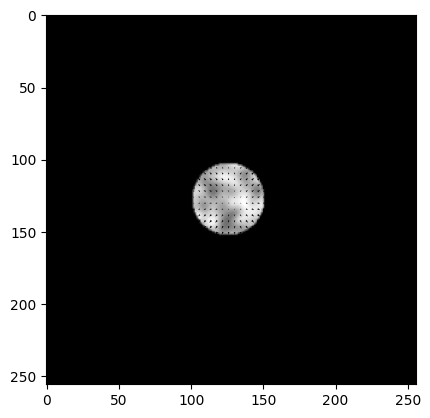

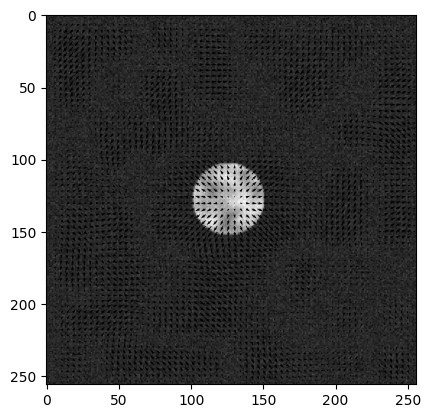

In [83]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

uInitial2 = mvf2[:,:,1]
vInitial2 = mvf2[:,:,0]
u2, v2 = HS(im2_noise, im1_noise, uInitial2, vInitial2, alpha, ite)
mvf_hs2 = np.zeros((np.shape(v2)[0],np.shape(v2)[1],2))
mvf_hs2[:,:,0] = v2
mvf_hs2[:,:,1] = u2
displayMVF(im1_noise,mvf_hs2,4)
bx2 = np.median(u2)
by2 = np.median(v2)
print(bx2)
print(by2)

The employment of fractional values for translations presents a distinct challenge for both block matching and optical flow methods regarding the precise estimation of movements.

**Block Matching Insights:**
- In the scenarios involving the noisy ball and Lena images, block matching approximations are adjusted to the closest whole numbers. This adaptation suggests that, although block matching is adept at leveraging the visual elements of an image to deduce movements, it encounters difficulties in achieving sub-pixel accuracy. Generally, block matching is tuned to work with the granularity of whole pixels, which inherently limits its precision for fractional translations unless it's specifically enhanced to accommodate sub-pixel estimations through techniques like interpolation.

**Optical Flow Insights:**
- Optical flow, on the other hand, yields estimations that more closely mirror the true fractional translations, particularly noticeable with the noisy ball image. This indicates a refined capability to detect sub-pixel shifts, a feature attributed to the method's foundation on the gradients of pixel intensities and the calculation of motion vectors poised for sub-pixel level precision. Nonetheless, for the Lena image, the optical flow's estimations diverge significantly from the actual translations. This divergence underscores possible constraints within the algorithm's processing of intricate textures and movement patterns on a sub-pixel scale. Such discrepancies could stem from the algorithm's specific sensitivity to motion details and the interpolation strategies employed for sub-pixel accuracy, which might not consistently correspond with complex or intricately textured scenes.